# XAI Proyecto Final - Titanic Dataset
**Model:** RandomForestClassifier  
**XAI techniques (3):**
1. **SHAP** (global + local)
2. **LIME** (local)
3. **Sanity check** (Randomise labels + Remove feature)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

import shap
from lime.lime_tabular import LimeTabularExplainer

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

np.random.seed(42)


## 1) Load data

In [ ]:
df = sns.load_dataset("titanic")

y = df["survived"]

X = df.drop(columns=["survived","alive","class","sex","who","embark_town","embarked","deck"])
X["adult_male"] = X["adult_male"].astype(int)
X["alone"] = X["alone"].astype(int)

# Fill missing age with mean
X["age"].fillna(X["age"].mean(), inplace=True)
print("X:", X.shape, "y:", y.shape)
X.head()

X: (891, 7) y: (891,)


/var/folders/j4/8tl4vt3557x7zkpxtchk1rth0000gn/T/ipykernel_89814/300434019.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["age"].fillna(X["age"].mean(), inplace=True)


,pclass,age,sibsp,parch,fare,adult_male,alone
0,3,22.0,1,0,7.2500,1,0
1,1,38.0,1,0,71.2833,0,0
2,3,26.0,0,0,7.9250,0,1
3,1,35.0,1,0,53.1000,0,0
4,3,35.0,0,0,8.0500,1,1


## 2) Train / Validation / Test split

In [ ]:
num_cols = X.columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols)
    ]
)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

## 3) Train model (Overfitting)

In [ ]:
# Model
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", model)
])

# Train
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'adult_male', 'alone'], dtype='object'))])),
                ('model',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=5,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [ ]:
# Probabilities
train_proba = pipe.predict_proba(X_train)[:, 1]
val_proba   = pipe.predict_proba(X_val)[:, 1]

# AUC
train_auc = roc_auc_score(y_train, train_proba)
val_auc   = roc_auc_score(y_val, val_proba)

print(f"Train AUC: {train_auc:.3f}")
print(f"Val   AUC: {val_auc:.3f}")


Train AUC: 0.939
Val   AUC: 0.895


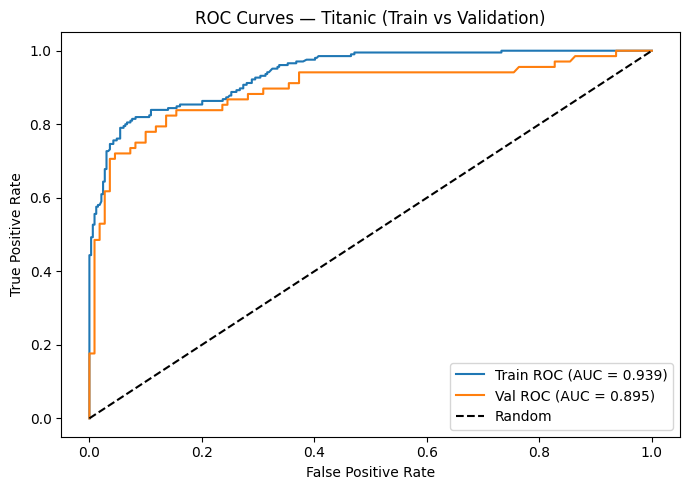

In [62]:
# ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, train_proba)
fpr_val, tpr_val, _     = roc_curve(y_val, val_proba)

plt.figure(figsize=(7,5))

plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {train_auc:.3f})")
plt.plot(fpr_val, tpr_val, label=f"Val ROC (AUC = {val_auc:.3f})")

plt.plot([0,1], [0,1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Titanic (Train vs Validation)")
plt.legend()
plt.tight_layout()
plt.show()


## 4) XAI 1 — SHAP Global

ExactExplainer explainer: 179it [00:15,  4.00it/s]                         


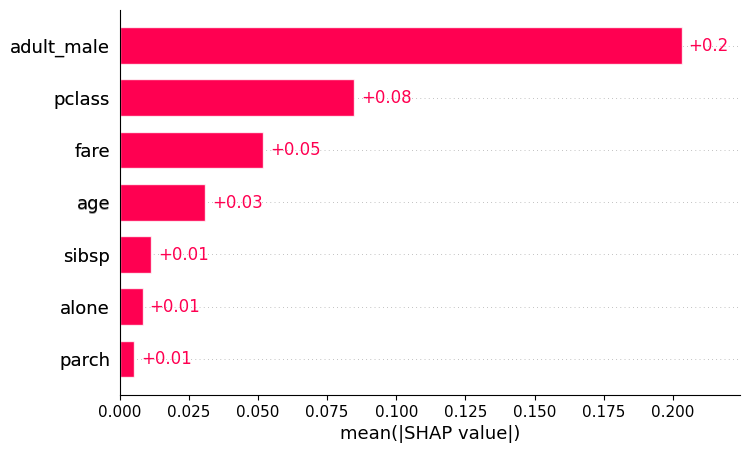

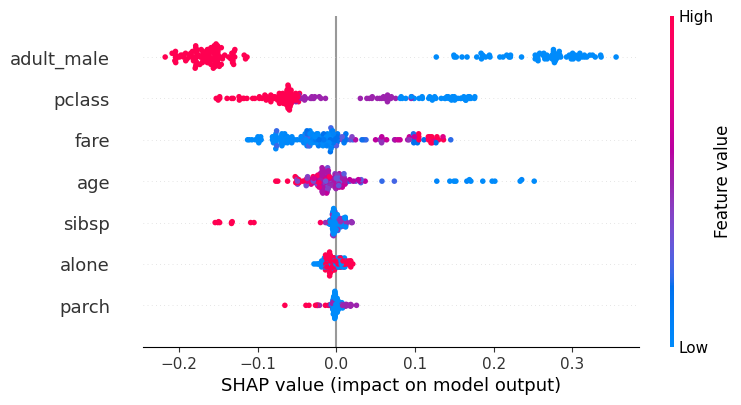

In [ ]:
bg = X_train.sample(200, random_state=42)

explainer = shap.Explainer(
    pipe.predict_proba,
    bg,
    feature_names=X.columns
)

sv = explainer(X_val)

sv_pos = sv[..., 1]

shap.plots.bar(sv_pos, max_display=10)

shap.plots.beeswarm(sv_pos, max_display=10)

## 5) XAI 2 — SHAP Local

In [84]:
i = 0
x_instance = X_val.iloc[[i]]
x_instance

,pclass,age,sibsp,parch,fare,adult_male,alone
320,3,22.0,0,0,7.25,1,1


In [ ]:
pre = pipe.named_steps["preprocess"]
clf = pipe.named_steps["model"]

feat_names = X.columns.to_list()

x_inst_t = pre.transform(x_instance)
explainer = shap.TreeExplainer(clf)

sv_all = explainer.shap_values(x_inst_t)
base_all = explainer.expected_value

if isinstance(sv_all, list):
    sv = sv_all[1][0]
    base = base_all[1]
else:
    sv = sv_all[0, :, 1]
    base = base_all[1] if hasattr(base_all, "__len__") else base_all

exp = shap.Explanation(
    values=sv,
    base_values=float(base),
    data=x_inst_t[0],
    feature_names=feat_names
)

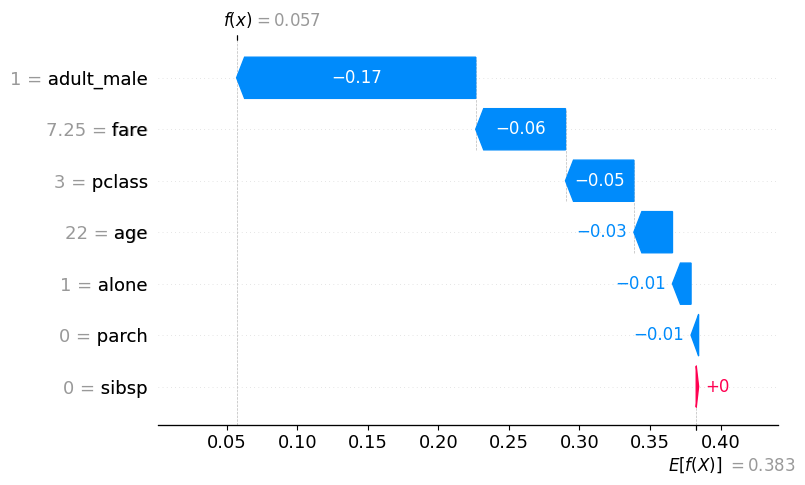

In [ ]:
shap.plots.waterfall(
    shap.Explanation(
        values=sv,
        base_values=base,
        data=x_inst_t[0],
        feature_names=X.columns.to_list()
    ),
    max_display=len(X.columns.to_list())
)


## LIME Local

In [ ]:
feature_names = X_train.columns.tolist()

def predict_fn_lime(X_arr):
    X_df = pd.DataFrame(X_arr, columns=feature_names)
    return pipe.predict_proba(X_df)

i = 0

x0 = X_val.iloc[i].values
true_label = y_val.iloc[i]

proba = pipe.predict_proba(X_val.iloc[[i]])[0]
pred  = int(proba[1] > 0.5)

print(f"True: {true_label}")
print(f"Pred: {pred}")
print(f"P(survived=1): {proba[1]:.3f}")

display(X_val.iloc[[i]])

True: 0
Pred: 0
P(survived=1): 0.057


,pclass,age,sibsp,parch,fare,adult_male,alone
320,3,22.0,0,0,7.25,1,1


In [95]:
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=["not_survived", "survived"],
    discretize_continuous=True,
    mode="classification",
    random_state=42
)

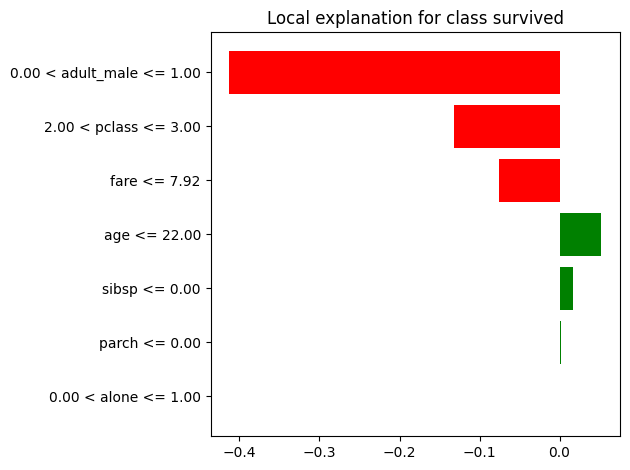

In [96]:
exp = explainer.explain_instance(
    data_row=x0,
    predict_fn=predict_fn_lime,
    num_features=len(feature_names),
    num_samples=5000
)

exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

## 6) XAI 3 — Sanity check / evaluation

### Sanity check 1 — Randomise labels


In [ ]:
def eval_auc(fitted_pipe, X_tr, y_tr, X_va, y_va):
    tr = fitted_pipe.predict_proba(X_tr)[:, 1]
    va = fitted_pipe.predict_proba(X_va)[:, 1]
    return roc_auc_score(y_tr, tr), roc_auc_score(y_va, va)

base_train_auc, base_val_auc = eval_auc(pipe, X_train, y_train, X_val, y_val)
print(f"Baseline AUC  train={base_train_auc:.3f}  val={base_val_auc:.3f}")

feat_names = X.columns.to_list()

mean_abs = np.mean(np.abs(sv_pos.values), axis=0)
imp = pd.Series(mean_abs, index=feat_names).sort_values(ascending=False)

print("Top SHAP features:")
display(imp)

top_k = 3
top_feats = imp.head(top_k).index.to_list()
low_feats = imp.tail(top_k).index.to_list()
print("Top feats:", top_feats)
print("Low feats:", low_feats)

Baseline AUC  train=0.939  val=0.895
Top SHAP features:


adult_male    0.203350
pclass        0.084852
fare          0.051962
age           0.030927
sibsp         0.011431
alone         0.008350
parch         0.005283
dtype: float64

Top feats: ['adult_male', 'pclass', 'fare']
Low feats: ['sibsp', 'alone', 'parch']


In [ ]:
rng = np.random.RandomState(42)

pipe_rand_y = clone(pipe)

y_train_shuf = pd.Series(rng.permutation(y_train.values), index=y_train.index)

pipe_rand_y.fit(X_train, y_train_shuf)
tr_auc, va_auc = eval_auc(pipe_rand_y, X_train, y_train_shuf, X_val, y_val)
print(f"Random-labels AUC  train={tr_auc:.3f}  val(real y)={va_auc:.3f}")

bg = X_train.sample(min(200, len(X_train)), random_state=42)
expl_rand = shap.Explainer(lambda Z: pipe_rand_y.predict_proba(Z)[:,1], bg)
sv_rand = expl_rand(X_val)

mean_abs_rand = np.mean(np.abs(sv_rand.values), axis=0)
imp_rand = pd.Series(mean_abs_rand, index=X.columns).sort_values(ascending=False)

print("Top SHAP (random labels):")
display(imp_rand)

Random-labels AUC  train=0.824  val(real y)=0.379


ExactExplainer explainer: 179it [00:15,  4.24it/s]                         

Top SHAP (random labels):


fare          0.040865
alone         0.030491
adult_male    0.023269
age           0.019452
pclass        0.011283
parch         0.010110
sibsp         0.006803
dtype: float64

### Sanity check 2 — Remove adult_male

In [100]:
tr_auc_base, va_auc_base = eval_auc(pipe, X_train, y_train, X_val, y_val)
print(f"BASELINE AUC  train={tr_auc_base:.3f}  val={va_auc_base:.3f}")

BASELINE AUC  train=0.939  val=0.895


In [ ]:
feat = "adult_male"

X_train_drop = X_train.drop(columns=[feat])
X_val_drop   = X_val.drop(columns=[feat])

pre_drop = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), X_train_drop.columns)
    ]
)

pipe_drop = Pipeline([
    ("preprocess", pre_drop),
    ("model", clone(model))
])

pipe_drop.fit(X_train_drop, y_train)

tr_auc_drop, va_auc_drop = eval_auc(
    pipe_drop,
    X_train_drop, y_train,
    X_val_drop, y_val
)

print(f"BASE Val AUC: {va_auc_base:.3f}")
print(f"DROP '{feat}' Val AUC: {va_auc_drop:.3f}")
print(f"Δ Val AUC: {va_auc_drop - va_auc_base:+.3f}")

BASE Val AUC: 0.895
DROP 'adult_male' Val AUC: 0.781
Δ Val AUC: -0.114
